<h2 align=center>Facial Expressions Convolutional Neural Network Training</h2>

### 1- Import Libraries

In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import os
from PIL import Image
import glob
from utils import *
import pathlib

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF

tf.compat.v1.disable_eager_execution()

### 2- Load and anlyze dataset

In [3]:
class_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
for folder in os.listdir("dataset/train/"):
    print(str(len(os.listdir("dataset/train/" + folder))) + " " + folder + " images")

3995 angry images
436 disgust images
4097 fear images
7215 happy images
4965 neutral images
4830 sad images
3171 surprise images


In [4]:
dataset_dir = pathlib.Path("dataset/train/")
total_image_count = len(list(dataset_dir.glob('*/*.jpg')))
print("Total dataset size is: " + str(total_image_count))

Total dataset size is: 28709


X_train shape: (28709, 48, 48)
Y_train shape: (28709, 1)


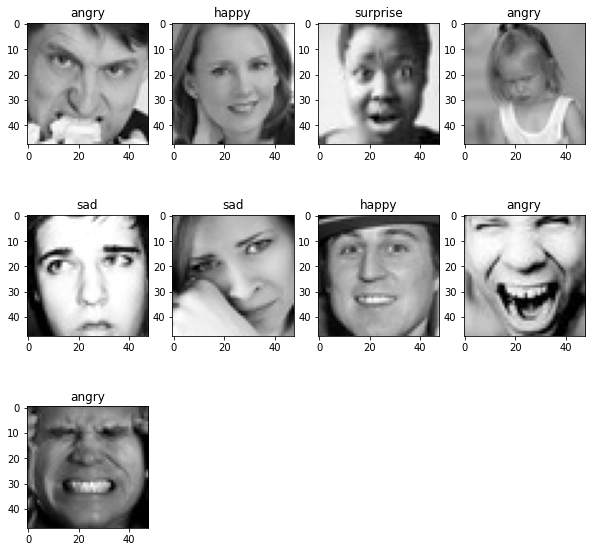

In [5]:
X_train, Y_train = load_dataset("dataset/train/")
X_test, Y_test = load_dataset("dataset/test/")
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))

plt.figure(figsize=(10, 10))
idx = np.random.choice(np.arange(len(X_train)), 9, replace=False)
for i, arr_index in enumerate(idx):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(X_train[arr_index], cmap='gray')
    plt.title(class_names[np.squeeze(Y_train[arr_index])])

In [6]:
Y_train = convert_to_one_hot(Y_train, 7).T
Y_test = convert_to_one_hot(Y_test, 7).T
print("First Y_train after one hot: ", Y_train[0])
print("Y _train shape after one hot: ", Y_train.shape)

First Y_train after one hot:  [1. 0. 0. 0. 0. 0. 0.]
Y _train shape after one hot:  (28709, 7)


### 3- Splitting into batches and image Augmentation

In [19]:
training_data = ImageDataGenerator(horizontal_flip=True, rescale=1./255,).flow_from_directory("dataset/train/",
                                                    target_size=(48, 48),
                                                    color_mode="grayscale",
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=True)


test_data = ImageDataGenerator(horizontal_flip=True, rescale=1./255,).flow_from_directory("dataset/test/",                           
                                                    target_size=(48, 48),
                                                    color_mode="grayscale",
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=False)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


###  4-Model

In [22]:
learning_rate = 0.012

model = Sequential()

model.add(Conv2D(128,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(7, activation='softmax'))

opt = Adam(learning_rate)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 48, 48, 128)       1280      
_________________________________________________________________
batch_normalization_18 (Batc (None, 48, 48, 128)       512       
_________________________________________________________________
activation_18 (Activation)   (None, 48, 48, 128)       0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 256)       819456    
_________________________________________________________________
batch_normalization_19 (Batc (None, 24, 24, 256)       1024      
_________________________________________________________________
activation_19 (Activation)   (None, 24, 24, 256)      

### 5- Training

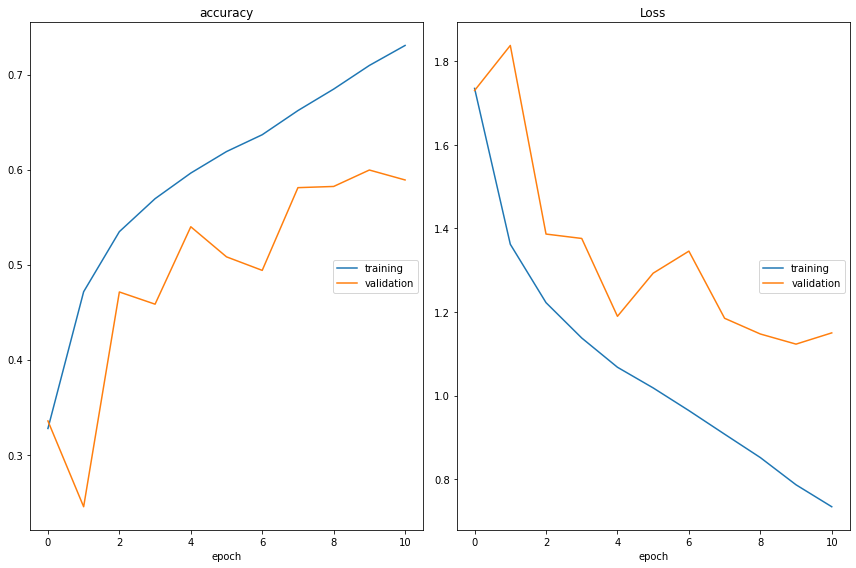

accuracy
	training         	 (min:    0.328, max:    0.731, cur:    0.731)
	validation       	 (min:    0.245, max:    0.600, cur:    0.589)
Loss
	training         	 (min:    0.734, max:    1.735, cur:    0.734)
	validation       	 (min:    1.123, max:    1.837, cur:    1.150)
897/897 [==============================] - 1035s 1s/step - batch: 448.0000 - size: 31.9699 - loss: 0.7350 - accuracy: 0.7307 - val_loss: 1.1501 - val_accuracy: 0.5891 - lr: 0.0120
Epoch 12/100
135/897 [===>..........................] - ETA: 13:46 - batch: 67.0000 - size: 32.0000 - loss: 0.6276 - accuracy: 0.7780

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.001, mode='auto')

callbacks = [PlotLossesKerasTF(), reduce_lr]

history = model.fit(
    x=training_data,
    steps_per_epoch=training_data.n//training_data.batch_size,
    epochs=100,
    validation_data = test_data,
    validation_steps = test_data.n//test_data.batch_size,
    callbacks=callbacks
)

### 6- Hyperparameter optimization